#**English-Chinese Translation with Attention-based Sequence-to-Sequence Model**



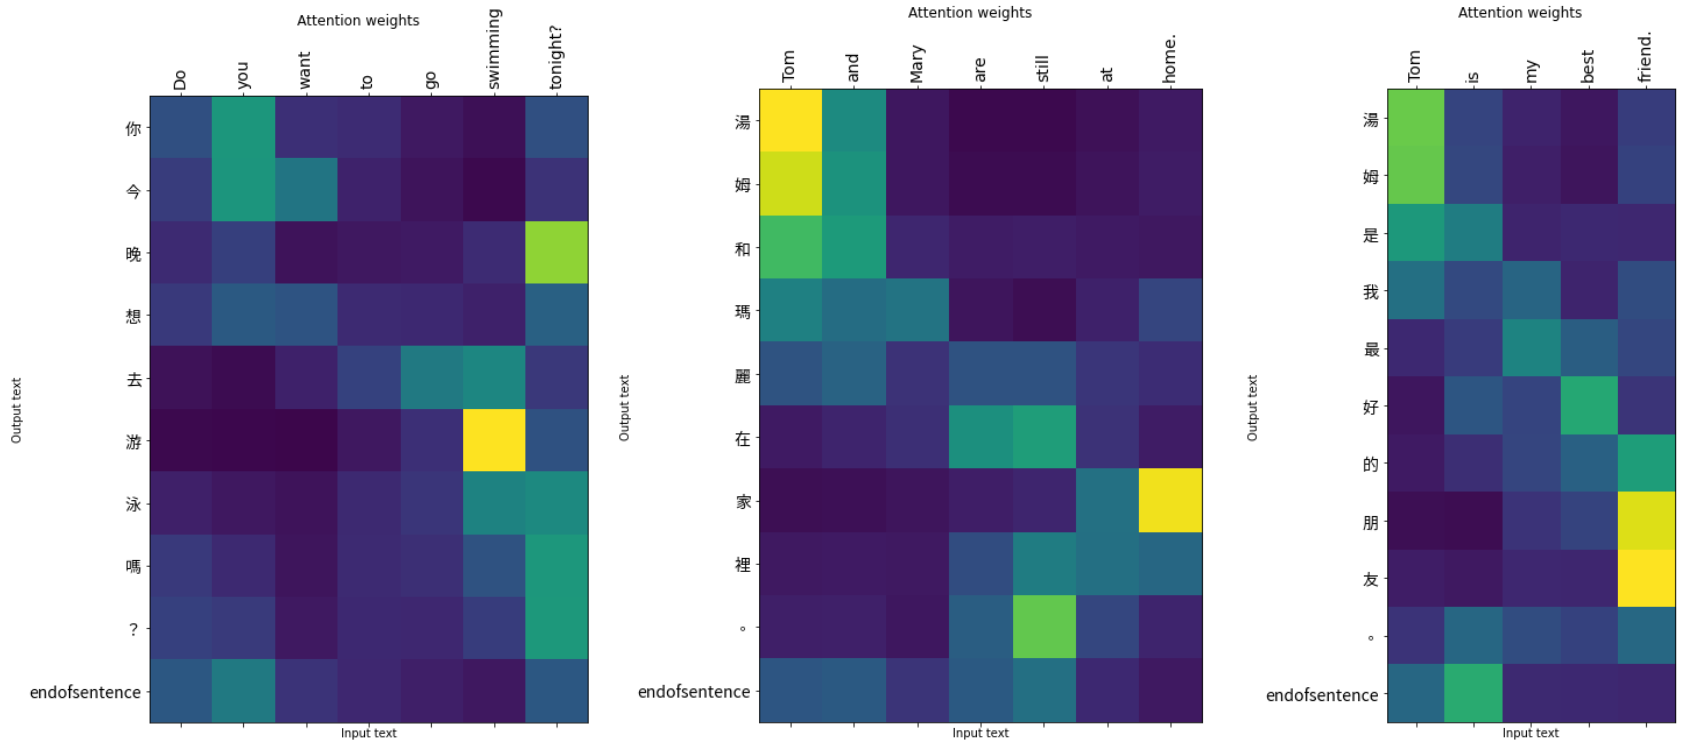


Tensorflow implementation of attention based seq-to-seq model for neural machine translation (NMT).

Overview of this project
- Objective: Translate English to Chinese 
- Dataset: English and Chinese pair from Anki
- Model: Attention based encoder decoder model (based on Mr. Aurélien Geron's NMT implementation with modifications to the attention layer used) 

This whole notebook was developed on Colab with GPU accelerated runtime.

If you are interested to see the results instead of training the model yourself, feel free to skip ahead to section 3.1 and load up the model I have trained. 

In [1]:
!python --version

Python 3.8.16


In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.0


### 1.0 - Data

In this section, we deal with getting the dataset ready for training our translation model. The data source is the English and Chinese translation pair from Anki (http://www.manythings.org/anki/cmn-eng.zip). The associated file is in tab separated format and we need to:
1. Extract the English and Chinese pair from each line
2. Perform the required pre-processing, such as simplified Chinese to traditional Chinese conversion and adding space between each Chinese character.
3. Adapt two text vectorizers on the English and Chinese text corpus, one for each language 
4. Format the input and output sequences according to the NMT model's requirement 

#### 1.1 - Download the dataset

Download and unzip the dataset using standard shell script.

In [3]:
!wget http://www.manythings.org/anki/cmn-eng.zip
!unzip cmn-eng.zip

--2022-12-21 04:03:52--  http://www.manythings.org/anki/cmn-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1270861 (1.2M) [application/zip]
Saving to: ‘cmn-eng.zip’

cmn-eng.zip         100%[===================>]   1.21M  3.16MB/s    in 0.4s    

2022-12-21 04:03:52 (3.16 MB/s) - ‘cmn-eng.zip’ saved [1270861/1270861]

Archive:  cmn-eng.zip
  inflating: cmn.txt                 
  inflating: _about.txt              


Get a feeling of the file by printing out the first 10 lines. As we can see, each line follows the pattern of ``English \t Chinese \t Attribution``.

In [4]:
!head -10 cmn.txt

Hi.	嗨。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)
Hi.	你好。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4857568 (musclegirlxyp)
Run.	你用跑的。	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #3748344 (egg0073)
Stop!	住手！	CC-BY 2.0 (France) Attribution: tatoeba.org #448320 (CM) & #448321 (GlossaMatik)
Wait!	等等！	CC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #4970122 (wzhd)
Wait!	等一下！	CC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #5092613 (mirrorvan)
Begin.	开始！	CC-BY 2.0 (France) Attribution: tatoeba.org #6102432 (mailohilohi) & #5094852 (Jin_Dehong)
Hello!	你好。	CC-BY 2.0 (France) Attribution: tatoeba.org #373330 (CK) & #4857568 (musclegirlxyp)
I try.	我试试。	CC-BY 2.0 (France) Attribution: tatoeba.org #20776 (CK) & #8870261 (will66)
I won!	我赢了。	CC-BY 2.0 (France) Attribution: tatoeba.org #2005192 (CK) & #5102367 (mirrorvan)


#### 1.2 - Prepare input and target pair

Since the dataset is in tab separated form, to use the data for our model, we need to split the lines into input and target pair.

In [5]:
import numpy as np

def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  np.random.seed(0)  
  np.random.shuffle(pairs)

  inp = [inp for inp, targ, _ in pairs]
  targ = [targ for inp, targ, _ in pairs]

  return targ, inp

In [6]:
from pathlib import Path

path_to_file = Path('./cmn.txt')
targ, inp = load_data(path_to_file)

#### 1.3 - (Optional) Convert simplified Chinese to traditional Chinese

The dataset is in simplifed Chinese, however, depending on your audience, traditional Chinese may be the desired target instead. Hence, it is necessary to perform some conversion, either at the time of dataset preparation (i.e. preprocess the inputs) or after inference by postprocessing the outputs. 

For illustrative purpose, we will adopt the preprocessing approach for the conversion here. 

There are a few libraries that are able to do the job and I have chosen one of the more popular libraries - OpenCC.



In [7]:
# convert simplified chinese to traditional chinese
!pip install opencc

import opencc
converter = opencc.OpenCC('s2hk.json')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 778 kB 17.2 MB/s 


#### 1.4 - Add space between Chinese characters

The output of each decoder step is a single Chinese character and, unlike English, Chinese words (characters) are not separated by space. Therefore, we need to preprocess the Chinese corpus by adding a space between each character. While the same can be achieved by specifying the ``split`` argument as ``character`` in the text vectorizer, it is a choice that I have made to explicitly show this major difference between English and Chinese.

In [8]:
# Add space between each Chinese character and perform simplified to traditional
# Chinese conversion if needed

sim_to_tr = True

if sim_to_tr:
  targ_space_separated = [' '.join(converter.convert(row)) for row in targ]
else:
  targ_space_separated = [' '.join(row) for row in targ]

In [9]:
# Check the dataset size
print(f'Chinese samples: {len(targ_space_separated)}, English samples: {len(inp)}')

Chinese samples: 29371, English samples: 29371


In [10]:
# Have a quick look at the dataset
for i in range(20000, 20020, 1):
  print(f'{inp[i]} => {targ_space_separated[i]}')

It's a clear day. => 天 空 很 晴 朗 。
Don't talk to me like this. => 不 要 這 樣 對 我 講 話 。
This old house is haunted. => 這 個 老 房 子 鬧 鬼 。
His life after retirement was unhappy. => 他 退 休 後 的 生 活 不 快 樂 。
I bet ten dollars on that horse. => 我 在 那 匹 馬 下 十 美 元 的 賭 注 。
I'm pregnant. => 我 懷 孕 了 。
You're the only one that can help us. => 你 是 唯 一 一 個 能 幫 助 我 們 的 人 。
It is rude to point at others. => 指 著 別 人 是 不 禮 貌 的 。
It's fun to ride a motorcycle. => 騎 摩 托 車 很 有 趣 。
I'm only thinking of you. => 我 只 想 到 你 。
That's all I could find. => 那 是 我 所 有 能 找 到 的 。
I like being on the team. => 我 喜 歡 在 隊 伍 裏 。
Tom is acting as if nothing has happened. => 湯 姆 像 什 麼 也 沒 發 生 一 樣 行 動 。
He had his hair cut short. => 他 把 頭 髮 剪 短 了 。
I ate lunch in a hurry. => 我 匆 忙 地 吃 了 午 飯 。
Tom has a good head on his shoulders. => 湯 姆 腦 瓜 靈 。
Keep your mouth shut and your eyes open. => 閉 嘴 看 着 。
The door is locked at nine o'clock. => 這 個 門 在 九 點 鐘 的 時 候 是 鎖 著 的 。 。
I am in touch with him. => 我 與 他 聯 繫 。
Don't worry about it. It's not 

In [11]:
# Assign the formatted text to its corresponding variable
sentences_en = inp
sentences_zh = targ_space_separated

#### 1.5 - Text vectorizer

After all, machine learning models work with numbers but not text. Before any training can be done, we need to convert our text into numbers/vectors. 

A common way of doing this is to first convert our text into a set of unique indices by using the ``TextVectorization`` layer; it learns the vocabulary from the training corpus. Then, the index is passed on to the ``Embedding`` layer for further encoding the information. 

Here, we will focus on the vectorization step first, essentially, it maps the token (be it a character or word) into its corresponding index. In general, each language would require its own vectorizer. 

In [12]:
# limit the vocab size
vocab_size = 1500

# limit the max sequence length 
max_length_en = 50
max_length_zh = 60

# Text vectorization layer for English
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length_en)

# Text vectorization layer for Chinese
text_vec_layer_zh = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length_zh)

# Learn the vocabulary from the training corpus by calling .adapt()
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_zh.adapt([f"startofseq {s} endofseq" for s in sentences_zh])

In [13]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'a', 'is', 'tom', 'he']

In [14]:
text_vec_layer_zh.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', '。', '我', '的', '了', '你', '他']

In [15]:
len(text_vec_layer_zh.get_vocabulary())

1500

In [16]:
train_size = int(len(sentences_en)*0.8)
train_size

23496

#### 1.6 - Tidy up the dataset

At this stage, our dataset is almost ready, however, there are 3 last steps that needs to be done:
1. Split the dataset into training and validation set, a standard 80:20 split is used.
2. Add the ``startofseq`` token to the beginning of the decoder input sequence, it is typically used as the first token to the decoder. 
3. The output sequences are the decoder's input sequences shifted one token to the left. Add the ``endofseq`` token to the end of the output sequences (i.e. the translated sentences), it is used to indicate the end of translation.

In [17]:
# Inputs -----------------------------------------------------------------------
# Input sequence to the encoder
X_train = tf.constant(sentences_en[:train_size])
X_valid = tf.constant(sentences_en[train_size:])

# Input sequence to the decoder, therefore, needs to add <SOS> token to the 
# beginning of the sentence
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_zh[:train_size]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_zh[train_size:]])

# Output -----------------------------------------------------------------------
# Output sequence of the decoder, therefore, needs to add <EOS> token to the 
# end of the sentence
Y_train = text_vec_layer_zh([f"{s} endofseq" for s in sentences_zh[:train_size]])
Y_valid = text_vec_layer_zh([f"{s} endofseq" for s in sentences_zh[train_size:]])


In [19]:
# Examine the dataset
print(f'Encoder input: {X_train[2]}')
print(f'Decoder input: {np.char.decode(X_train_dec[0:10].numpy()[2], encoding="utf-8")}')
print(f'Decoder output: {Y_train[2]}')

Encoder input: b'You look tired. You ought to rest for an hour or two.'
Decoder input: startofseq 你 看 起 來 很 累 。 你 應 該 休 息 一 兩 個 小 時 。
Decoder output: [  8  45  69  29  25 499   4   8 125  77 482 366  13 202  20 107  43   4
   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


### 2.0 - Model 

In this section, we are going to 
1. build the encoder-decoder model with attentions using the Tensorflow functional API
2. train the model with the English-Chinese pairs.

#### 2.1 - Model architecture

The model architecture we will be using is based on the amazingly clear implementation in the book by Mr. Aurélien Geron. Unfortunately, even by the standard of a toy translator, the Attention layer used in his model did not give satisfying results when trained on our dataset. Hence, I have replaced the attention layer with the MultiHeadAttention layer used in the official Tensorflow tutorial and the performance seemed to be more reasonable. To be concrete, the model architecture is illustrated as below:

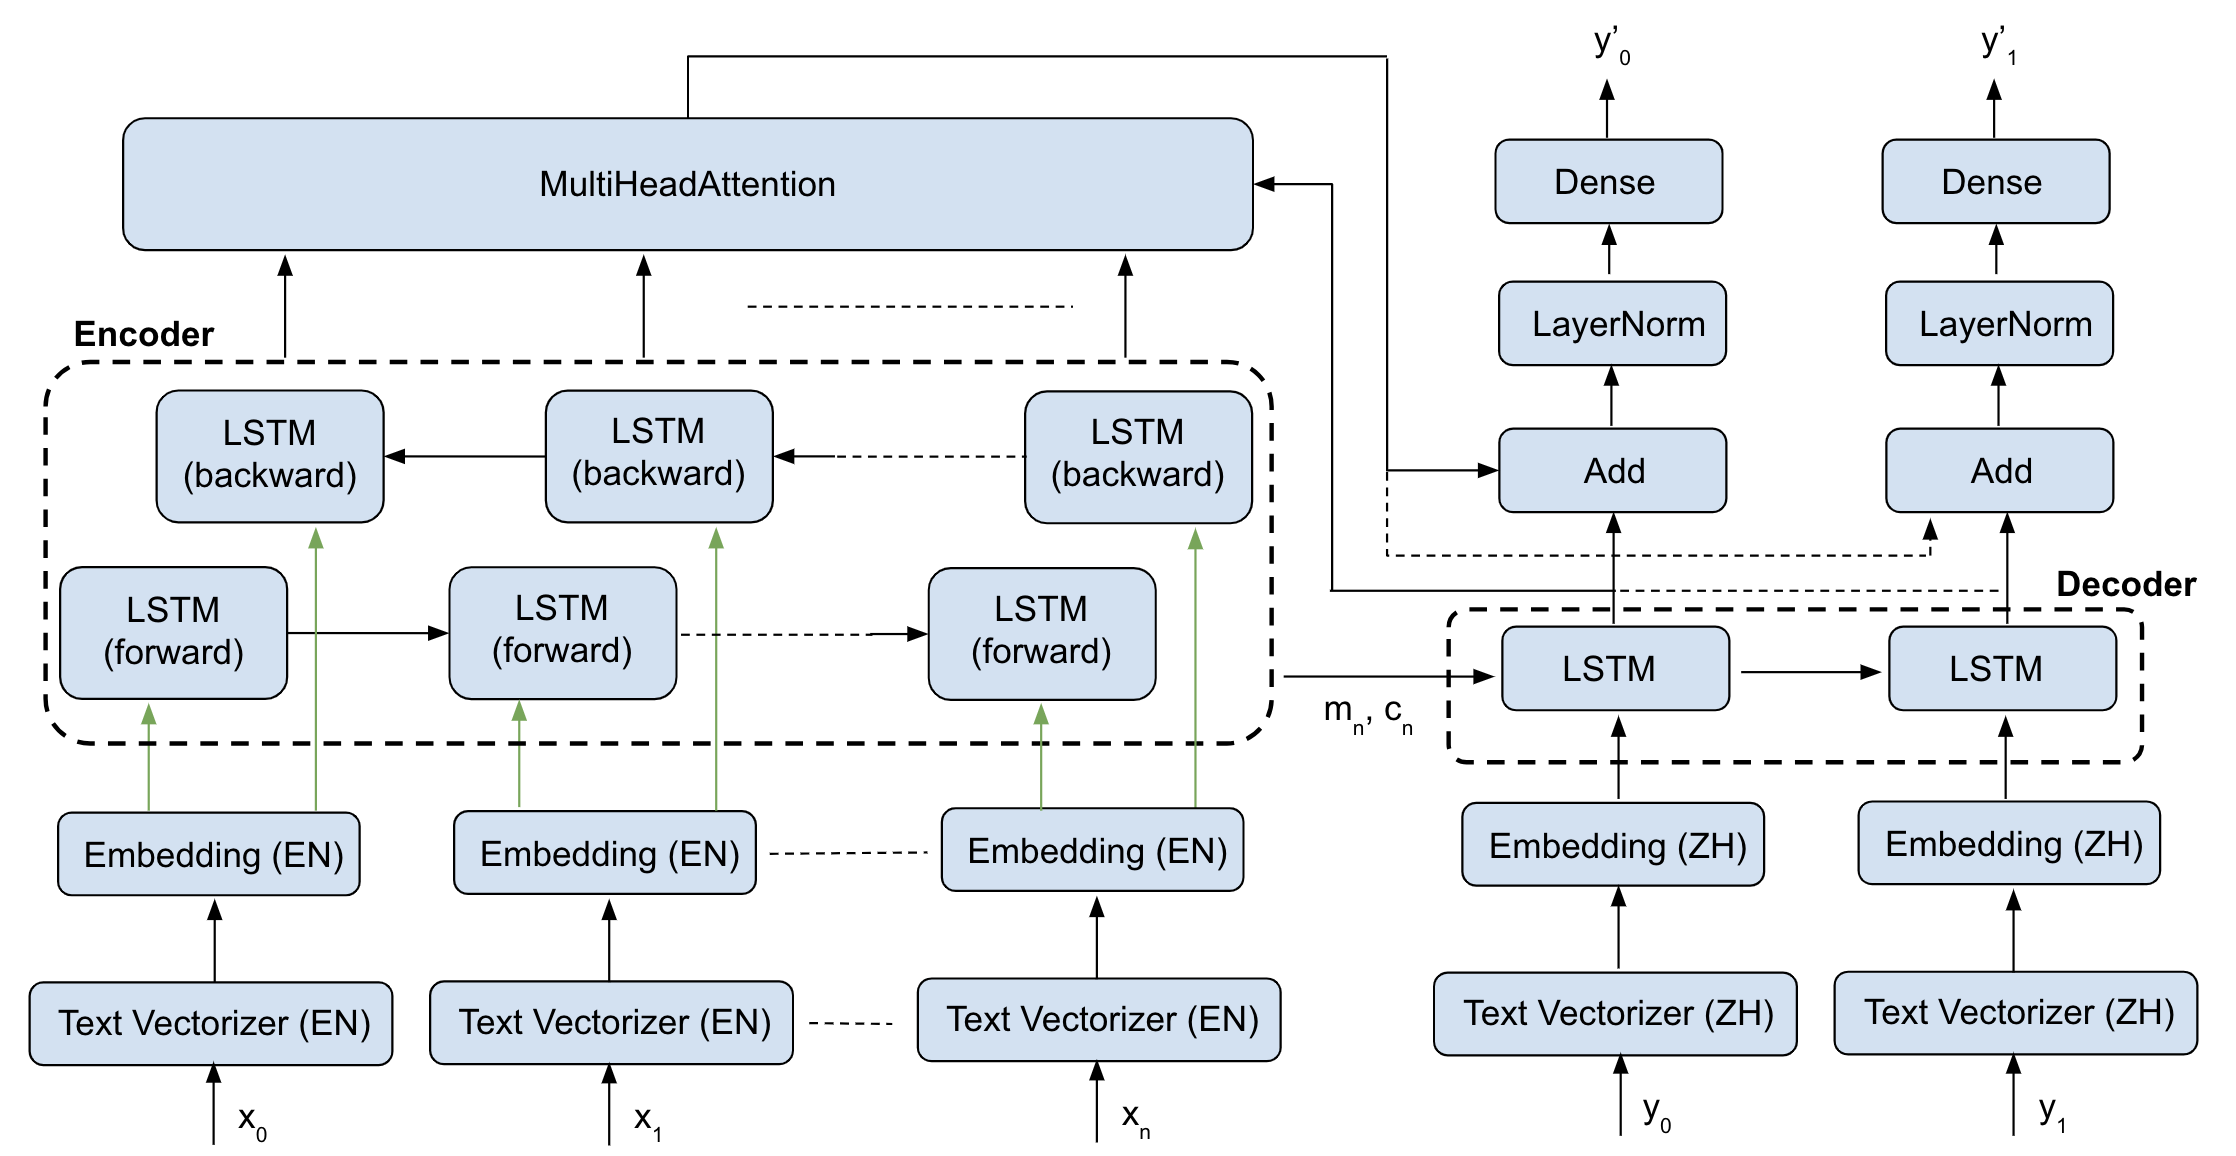

#### 2.2 - Input layer

In [20]:
tf.random.set_seed(0)  # extra code – ensures reproducibility on CPU

encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

#### 2.3 - Embeddings

In [21]:
embed_size = 128

encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_zh(decoder_inputs)

encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

#### 2.4 - Encoder and decoder

In [22]:
# make sure the return sequences parameter is set to True
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

In [23]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

#### 2.5 - Attentions 

In [24]:
attention_layer = tf.keras.layers.MultiHeadAttention(key_dim=512, num_heads=1, name='attentions')
attention_outputs, attention_scores = attention_layer(query=decoder_outputs,
                                                      value=encoder_outputs,
                                                      return_attention_scores=True)

In [25]:
x = tf.keras.layers.Add()([attention_outputs, decoder_outputs])
x = tf.keras.layers.LayerNormalization()(x)

#### 2.5 - Output

In [26]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(x)

#### 2.6 - Model definition

In [27]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 50)          0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      192000      ['text_vectorization[0][0]'] 

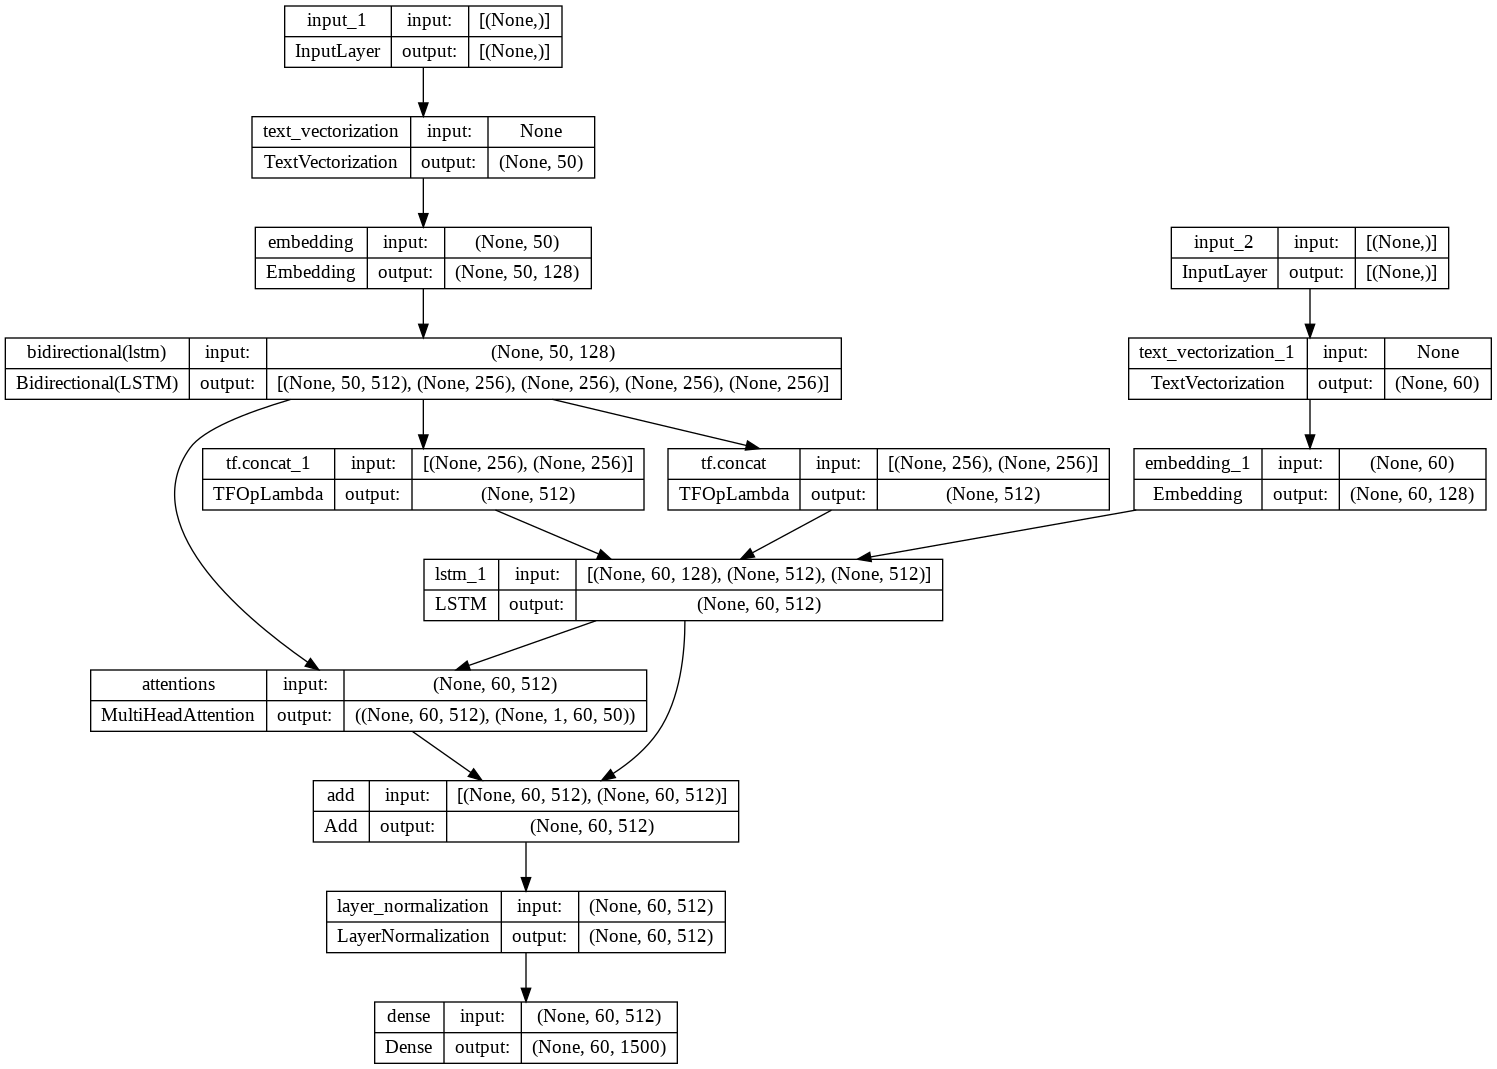

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### 2.7 - Model training

In [29]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=3,
                                                           restore_best_weights=False)

In [30]:
model.compile(loss="sparse_categorical_crossentropy", 
             optimizer="adam",
             metrics=["accuracy"])

model.fit((X_train, X_train_dec), Y_train, epochs=20,
          validation_data=((X_valid, X_valid_dec), Y_valid), callbacks=[early_stopping_callback])

Epoch 1/20
735/735 [==============================] - 43s 37ms/step - loss: 0.5895 - accuracy: 0.4281 - val_loss: 0.4547 - val_accuracy: 0.5159
Epoch 2/20
735/735 [==============================] - 23s 31ms/step - loss: 0.3808 - accuracy: 0.5685 - val_loss: 0.3871 - val_accuracy: 0.5701
Epoch 3/20
735/735 [==============================] - 23s 32ms/step - loss: 0.3059 - accuracy: 0.6275 - val_loss: 0.3646 - val_accuracy: 0.5948
Epoch 4/20
735/735 [==============================] - 23s 32ms/step - loss: 0.2554 - accuracy: 0.6713 - val_loss: 0.3593 - val_accuracy: 0.6074
Epoch 5/20
735/735 [==============================] - 23s 31ms/step - loss: 0.2140 - accuracy: 0.7112 - val_loss: 0.3592 - val_accuracy: 0.6167
Epoch 6/20
735/735 [==============================] - 23s 32ms/step - loss: 0.1771 - accuracy: 0.7495 - val_loss: 0.3650 - val_accuracy: 0.6214
Epoch 7/20
735/735 [==============================] - 24s 33ms/step - loss: 0.1447 - accuracy: 0.7874 - val_loss: 0.3800 - val_accuracy:

#### 2.8 - (Optional) Model saving and loading

In [31]:
# model.save('./model/nmt_model')

In [32]:
# !zip -r ./model/nmt_model.zip ./model/nmt_model

### 3.0 - Translation performance 

In this section, we will examine how our model performs.



#### (Optional) 3.1 - Load the saved model

If you would like to skip the training part, you can simply load up the resulting model that I had trained. 

In [33]:
# !unzip ./model/nmt_model.zip 

In [34]:
# import tensorflow as tf
# # load model
# model = tf.keras.models.load_model('./model/nmt_model')
# model.summary()

#### 3.2 - Translation

In [35]:
max_length = 60

In [36]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec), verbose=0)[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_zh.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [37]:
sentence_test = "I like to play football."
translate(sentence_test)

'我 喜 歡 踢 足 球 。'

In [38]:
sentence_test = "Tom is a good friend of mine."
translate(sentence_test)

'湯 姆 是 我 的 好 朋 友 。'

In [39]:
sentence_test = "Did you go swimming yesterday?"
translate(sentence_test)

'你 昨 天 去 游 泳 嗎 ？'

#### 3.3 - Visualization

Generates the attention plots.

In [40]:
# Get chinese font package for matplotlib
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.8/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 

myfont = FontProperties(fname=r'/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')


--2022-12-21 04:09:23--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.111.101, 142.251.111.100, 142.251.111.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.111.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/omgukq3btt7k0g330gq146bqj4ek1cbi/1671595725000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=8854a78f-6e0f-44c2-a7bc-8e433f278378 [following]
--2022-12-21 04:09:24--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/omgukq3btt7k0g330gq146bqj4ek1cbi/1671595725000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=8854a78f-6e0f-44c2-a7bc-8e433f278378
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.163.132, 2607:f8b0:4004:c1b::84
Connecting to d

In [41]:
# Create a new visualization model to output the attention weights
visualization_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("attentions").output)

In [42]:
def calculate_attention_scores(input_sentence):
  
  predicted_sentence = 'startofseq ' + translate(input_sentence)
  print(f'{input_sentence} => {predicted_sentence}')

  X_enc = np.array([input_sentence])
  X_dec = np.array([predicted_sentence])

  _, attentions = visualization_model.predict((X_enc, X_dec))

  return attentions, predicted_sentence

input_sentence = "Do you want to go swimming tonight?"
_, _ = calculate_attention_scores(input_sentence)

Do you want to go swimming tonight? => startofseq 你 今 晚 想 去 游 泳 嗎 ？
1/1 [==============================] - 3s 3s/step


In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def plot_attention(attention, sentence, predicted_sentence):

  sentence = sentence.split()
  predicted_sentence = predicted_sentence.split()
  
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  # Get the attention scores for the input and output sentences
  attention = attention[:len(predicted_sentence)-1, :len(sentence)]

  # Normalize the attention scores
  attention = attention/np.sum(attention, axis=1, keepdims=True)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence[1:], fontdict=fontdict,fontproperties=myfont)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [44]:
def translate_and_plot(input_sentence):
  attentions, predicted_sentence = calculate_attention_scores(input_sentence)
  plot_attention(attentions[0][0], input_sentence, predicted_sentence + " endofsentence")


Do you want to go swimming tonight? => startofseq 你 今 晚 想 去 游 泳 嗎 ？
1/1 [==============================] - 0s 18ms/step


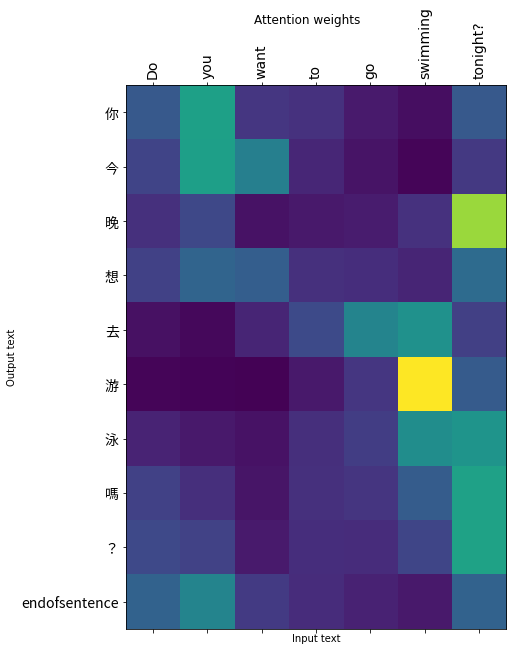

In [45]:
input_sentence = "Do you want to go swimming tonight?"
translate_and_plot(input_sentence)

Tom is my best friend. => startofseq 湯 姆 是 我 最 好 的 朋 友 。
1/1 [==============================] - 0s 25ms/step


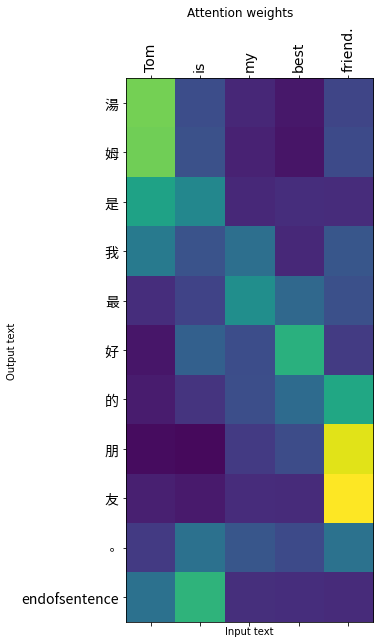

In [46]:
input_sentence = "Tom is my best friend."
translate_and_plot(input_sentence)

Tom and Mary are still at home. => startofseq 湯 姆 和 瑪 麗 在 家 裡 。
1/1 [==============================] - 0s 22ms/step


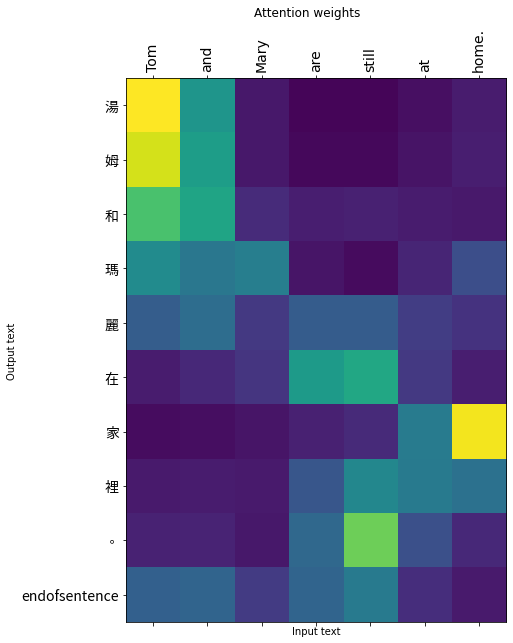

In [47]:
input_sentence = "Tom and Mary are still at home."
translate_and_plot(input_sentence)